In [1]:
import pickle
from timeit import default_timer as timer

import os
import platform
import tensorflow as tf
import keras;

# *print ("Current file path: {}".format(os.path.dirname(os.path.realpath(__file__))))
print ("Current Working Directory: {}".format(os.getcwd()))
print("Python: {}, TensorFlow:{}, Keras:{}".\
      format(platform.python_version(), tf.__version__, keras.__version__))

random_seed = 1



Using TensorFlow backend.


Current Working Directory: /home/endre/git/finance_ml/src
Python: 3.6.1, TensorFlow:1.2.1, Keras:2.0.5


# Load pickled Features, Labels and Name of each Feature-array

In [2]:
print ("De-pickling features, labels and feature/label names..")
load_start = timer()

# pickled = pickle.load(open("RangeNamesFeaturesAndLabels-mk1.pickle", "rb"))
# pickled = pickle.load(open("RangeNamesFeaturesAndLabels-smallSet-6stocks.pickle", "rb"))
# pickled = pickle.load(open("RangeNamesFeaturesAndLabels-smallSet-50stocks.pickle", "rb"))
pickled = pickle.load(open("RangeNamesFeaturesAndLabels-mediumset-unknownNumStocks.pickle", "rb"))
# pickled = pickle.load(open("RangeNamesFeaturesAndLabels-largeSet-1619stocks.pickle", "rb"))

load_millis = (timer()-load_start) * 1000
print ("De-pickle took {} ms".format(load_millis))

# {'rangeNames': rangeNames, 'features': features, 'labels': labels}
rangeNames = pickled['rangeNames']
features = pickled['features']
labels = pickled['labels']
print("\nRangeNames/features/labels len: {}/{}/{}".\
      format(len(rangeNames), len(features), len(labels)))
numFeatures = len(features[0])
print("\nNumber of Features for each feature-array: {}".format(numFeatures))
print("Number of Labels for each label-array: {}".format(len(labels[0])))

De-pickling features, labels and feature/label names..
De-pickle took 23844.117800996173 ms

RangeNames/features/labels len: 1008922/1008922/1008922

Number of Features for each feature-array: 54
Number of Labels for each label-array: 4


# Split set into Train and Test

In [3]:
import resource
import gc
def mem():
    print('Memory usage: %2.2f MB' % round(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024.0,1))
    
mem()
trainRangeNames = []
trainFeatures = []
trainLabels = []

testRangeNames = []
testFeatures = []
testLabels = []
mem()

gc.collect()
mem()

length = len(rangeNames)
for i in range(length):
    names = rangeNames[i]
    if (names[1] < '2016-01-01'):
        trainRangeNames.append(names)
        trainFeatures.append(features[i])
        trainLabels.append(labels[i])
    else:
        testRangeNames.append(names)
        testFeatures.append(features[i])
        testLabels.append(labels[i])

lenTrainFeatures = len(trainFeatures)

print("TRAIN RangeNames/features/labels len: {}/{}/{} - {:.2f}% of total".\
      format(len(trainRangeNames), lenTrainFeatures, len(trainLabels), (lenTrainFeatures / len(features)) * 100 ))
print("TEST RangeNames/features/labels len: {}/{}/{} - {:.2f}% of total".\
      format(len(testRangeNames), len(testFeatures), len(testLabels), (len(testFeatures) / len(features)) * 100 ))

print("\nTotal loaded features: {}, trainFeatures + testFeatures:{} - {:.4f}%".\
      format(len(features), lenTrainFeatures + len(testFeatures), ((lenTrainFeatures + len(testFeatures)) / len(features)) * 100))

Memory usage: 7895.10 MB
Memory usage: 7895.10 MB
Memory usage: 7895.10 MB
TRAIN RangeNames/features/labels len: 939830/939830/939830 - 93.15% of total
TEST RangeNames/features/labels len: 69092/69092/69092 - 6.85% of total

Total loaded features: 1008922, trainFeatures + testFeatures:1008922 - 100.0000%


In [8]:
# One-hot the labels

num_classes = 2

# 0:  5 days
# 1: 10 days
# 2: 15 days
# 3: 20 days
label_to_use = 3

good = [1,0]
bad =  [0,1]

trainLabels_onehot = [good if x[label_to_use] > 0 else bad  for x in trainLabels]
testLabels_onehot = [good if x[label_to_use] > 0 else bad  for x in testLabels]
print("One-hotted ok.")

sum_trainLabels = [sum(i) for i in zip(*trainLabels_onehot)]
sum_testLabels = [sum(i) for i in zip(*testLabels_onehot)]
print("Train labels [good, bad]: {} -> [{:.2f}%, {:.2f}%]".\
      format(sum_trainLabels, (sum_trainLabels[0] / len(trainLabels)) * 100, (sum_trainLabels[1] / len(trainLabels)) * 100))
print("Test labels  [good, bad]: {} -> [{:.2f}%, {:.2f}%]".\
      format(sum_testLabels, (sum_testLabels[0] / len(testLabels)) * 100, (sum_testLabels[1] / len(testLabels)) * 100))

One-hotted ok.
Train labels [good, bad]: [505724, 434106] -> [53.81%, 46.19%]
Test labels  [good, bad]: [39999, 29093] -> [57.89%, 42.11%]


# !! RUN FROM HERE WHEN ONLY TWEAKING NETWORK !!

In [18]:
from sklearn.utils import shuffle
import numpy as np

currentTrainPos = 0
current_shuffle = 0
shuff_trainFeatures = []
shuff_trainLabels_onehot = []
def getTrainMiniBatch(miniBatchSize):
    global currentTrainPos, current_shuffle
    global shuff_trainFeatures, shuff_trainLabels_onehot
    # If we'll overflow the features list with this mini_batch, then reset the start position
    if (currentTrainPos + miniBatchSize > lenTrainFeatures):
        currentTrainPos = 0

    # If the start position is 0, then run shuffling of features and labels.
    if (currentTrainPos == 0):
        print("Shuffling training features and labels - {}..".format(current_shuffle))
        shuff_trainFeatures, shuff_trainLabels_onehot = shuffle(trainFeatures, trainLabels_onehot, random_state=current_shuffle)
        current_shuffle += 1

    # Pick out the desired mini_batch size.
    start = currentTrainPos
    end = currentTrainPos + miniBatchSize
    # .. store this mini_batch end pos as the next mini_batch start pos.
    currentTrainPos = end
    
    return np.array(shuff_trainFeatures[start:end]) / 100.0, np.array(shuff_trainLabels_onehot[start:end])
    # return shuff_trainFeatures[start:end], shuff_trainLabels_onehot[start:end]

# Set up Neural Network

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dropout(0.1, input_shape=(numFeatures,)))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(160, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_6 (Dropout)          (None, 54)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 800)               44000     
_________________________________________________________________
dropout_7 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 160)               128160    
_________________________________________________________________
dropout_8 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 800)               128800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 800)               0         
__________

# Train Neural Network

Running process: [timeout 300 nvidia-smi --query-gpu=utilization.gpu,utilization.memory --format=csv,nounits -lms 100 -f GPU-info.csv]
NOTE! Using THREADS for Generator!


Shuffling training features and labels - 0..


Shuffling training features and labels - 1..


Shuffling training features and labels - 2..


Shuffling training features and labels - 3..


Shuffling training features and labels - 4..


Shuffling training features and labels - 5..


Shuffling training features and labels - 6..


Shuffling training features and labels - 7..


Shuffling training features and labels - 8..


Shuffling training features and labels - 9..


Shuffling training features and labels - 10..


Shuffling training features and labels - 11..


Shuffling training features and labels - 12..


Shuffling training features and labels - 13..


Shuffling training features and labels - 14..


Shuffling training features and labels - 15..


Shuffling training features and labels - 16..


Shuffling training features and labels - 17..


Shuffling training features and labels - 18..


Shuffling training features and labels - 19..


Shuffling training features and labels - 20..


Shuffling training features and labels - 21..


Shuffling training features and labels - 22..


Shuffling training features and labels - 23..


Shuffling training features and labels - 24..


Shuffling training features and labels - 25..


Shuffling training features and labels - 26..


Shuffling training features and labels - 27..


Shuffling training features and labels - 28..


Shuffling training features and labels - 29..


Shuffling training features and labels - 30..


Shuffling training features and labels - 31..


Shuffling training features and labels - 32..


Shuffling training features and labels - 33..


Shuffling training features and labels - 34..


Shuffling training features and labels - 35..


Shuffling training features and labels - 36..


Shuffling training features and labels - 37..


Shuffling training features and labels - 38..


Shuffling training features and labels - 39..


Shuffling training features and labels - 40..


Shuffling training features and labels - 41..


Shuffling training features and labels - 42..


Shuffling training features and labels - 43..


Shuffling training features and labels - 44..


Shuffling training features and labels - 45..


Shuffling training features and labels - 46..


Shuffling training features and labels - 47..


Shuffling training features and labels - 48..


Shuffling training features and labels - 49..


Shuffling training features and labels - 50..



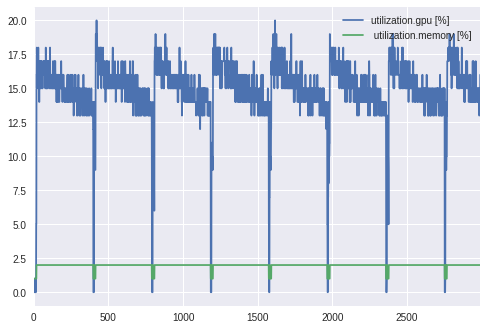

Test loss: 6.07913039262
Test accuracy: 0.517816823945
Baseline Error: 48.22%
TRAINING took 1959.6455657309998 seconds.


In [20]:
from keras_tqdm import TQDMNotebookCallback

batch_size = 128
epochs = 50
train_size = lenTrainFeatures

# ----------
import subprocess
import shlex
nvidia_smi_max_timeout = 300
cmd = 'timeout {} nvidia-smi'+\
      ' --query-gpu=utilization.gpu,utilization.memory'+\
      ' --format=csv,nounits -lms 100 -f GPU-info.csv'
cmd = cmd.format(nvidia_smi_max_timeout)
print("Running process: [{}]".format(cmd))
nvidia_smi = subprocess.Popen(shlex.split(cmd))
# ----------

# Whether to use processes or threads
# True => Processes, False => Threads
if ('use_multiprocessing' in vars()):
    multiprocessing=use_multiprocessing
else:
    multiprocessing=False

print("NOTE! Using {} for Generator!"\
      .format('PROCESSES' if multiprocessing else 'THREADS'))

# Stolen from https://github.com/fchollet/keras/issues/1638
import threading
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return self.it.__next__()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g


@threadsafe_generator
def data_generator_mnist_train():
    while True:
        yield getTrainMiniBatch(batch_size)

time_start = timer()
history = model.fit_generator(data_generator_mnist_train(), 
                              steps_per_epoch=int(train_size/batch_size),
                              epochs=epochs, 
                              workers=2, pickle_safe=multiprocessing,
                              verbose=0, callbacks=[TQDMNotebookCallback()],
                              validation_data=[testFeatures, testLabels_onehot],
                              max_q_size=50)
training_time = timer()-time_start

scores = model.evaluate(testFeatures, testLabels_onehot, verbose=0)

# ----------
import time
time.sleep(0.5)
nvidia_smi.terminate()
time.sleep(0.5)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("darkgrid")
gpu = pd.read_csv("./GPU-info.csv")
gpu.plot()
plt.show()
# ----------

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print("Baseline Error: {:.2f}%".format(100-scores[1]*100))
print("TRAINING took {} seconds.".format(training_time))